<center>
<h1>Reinforcement Learning</h1>
<h1 style="color:blue">Defining & Solving RL Environments</h1>
</center>

## Lawn Mower - Deterministic

In [ ]:
!pip install gym

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached optuna-3.4.0-py3-none-any.whl.metadata (17 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
  Using cached Mako-1.3.0-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-3.4.0-py3-none-any.whl (409 kB)
   ---------------------------------------- 0.0/230.6 kB ? eta -:--:--
   ---------------------------------------  225.3/230.6 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 230.6/230.6 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.1 MB 11.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/2.1 MB 4.1 MB/s eta 0:

In [ ]:
!pip install cv2

In [ ]:
# import cv2
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import optuna


C:\Users\91740\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### STEP 1
Choose a scenario for your grid world. You are welcome to use the RL env visualization demo as a reference to visualize it.
An example of idea for RL environment:
- Theme: Lawnmower Grid World with batteries as positive rewards and rocks as negative rewards.
- States: {S1 = (0,0), S2 = (0,1), S3 = (0,2), S4 = (0,3), S5 = (1,0), S6 = (1,1), S7 = (1,2), S8 = (1,3), S9 = (2,0), S10 = (2,1), S11 = (2,2), S12 = (2,3), S13 = (3,0), S14 = (3,1), S15 = (3,2), S16 = (3,3)}
- Actions: {Up, Down, Right, Left}
- Rewards: {-5, -6, +5, +6}
- Objective: Reach the goal state with maximum reward

#### Lawnmower Grid World with batteries as positive rewards and rocks as negative rewards

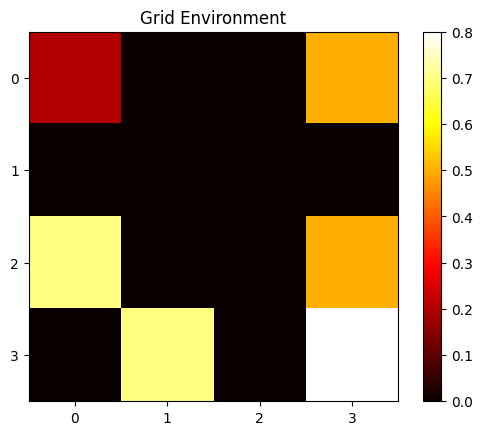

In [ ]:
# start position of our agent
pos1 = [0, 0]  

# goal position of our agent
pos2 = [3, 3]  

# battery positions
b1 = [0, 3]
b2 = [2, 3]

# ROck positions
r1 = [2, 0]
r2 = [3, 1]

# Creating the grid
grid = np.zeros((4, 4))
grid[tuple(pos1)] = 0.2
grid[tuple(pos2)] = 0.8
grid[tuple(b1)] = 0.5
grid[tuple(b2)] = 0.5
grid[tuple(r1)] = 0.7
grid[tuple(r2)] = 0.7

# Display the grid
plt.imshow(grid,  cmap='hot',vmin=0)
plt.colorbar()
plt.xticks(np.arange(0, 4, 1))
plt.yticks(np.arange(0, 4, 1))
plt.gca().set_xticklabels(np.arange(0, 4, 1)) 
plt.gca().set_yticklabels(np.arange(0, 4, 1)) 
plt.title('Grid Environment')
plt.show()


### STEP 2
Define an RL environment following the scenario that you chose. Environment requirements:

- Min number of states: 12
- Min number of actions: 4
- Min number of rewards: 4

Environment definition should follow the Gymnasium structure, which includes the basic methods. You can use RL Environment demo as a base code.

```
def init__:
# Initializes the class
# Define action and obs space

def step:
# Executes one timestep within the environment # Input to the function is an action

def reset:
# Resets the state of the environment to an initial state

def render:
# Visualizes the environment
# Any form like vector representation or visualizing usingmatplotlib is sufficient
```

In [ ]:
class MyLawn(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha

        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.battery_loc = [np.asarray([0, 3]), np.asarray([2, 3])]
        self.rock_loc = [np.asarray([2, 0]), np.asarray([3, 1])]

        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.battery_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.rock_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))  
        self.prev_action = None  
        self.flag_out = 0 
        self.penalty_counter = 0

    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.battery_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.rock_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def step(self, action):
        self.prev_state = np.copy(self.state)  
        self.prev_action = action  
        self.flag_out = 0  

        if action == 0:  
            self.myagent[0] += 1
        elif action == 1:
            self.myagent[0] -= 1
        elif action == 2:
            self.myagent[1] += 1
        elif action == 3:
            self.myagent[1] -= 1

        self.myagent = np.clip(self.myagent, 0, 3)

        # If the agent is in the same position as the previous step, choose a different action
        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myagent, prev_state_positions[0]):
            while action == self.prev_action:
                action = self.action_space.sample()
            self.flag_out = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.battery_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.rock_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myagent, pos) for pos in self.rock_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated = True if np.array_equal(self.myagent, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myagent < 0) | (self.myagent > 3)) else False
        if truncated:
            self.flag_out = 1  

        info = {}

        return self.state.flatten(), reward, terminated, truncated, info

    def calculate_reward(self):
        prev_myagentitions = np.argwhere(self.prev_state == 0.2)
        if prev_myagentitions.size == 0:
            prev_myagentition = self.myagent
        else:
            prev_myagentition = prev_myagentitions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myagentition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myagent)

        if np.array_equal(self.myagent, self.goal_loc):
            reward = 10
        elif np.array_equal(self.myagent, self.rock_loc[0]):
            reward = -5
        elif np.array_equal(self.myagent, self.rock_loc[1]):
            reward = -6
        elif np.array_equal(self.myagent, self.battery_loc[0]):
            reward = 5
        elif np.array_equal(self.myagent, self.battery_loc[1]):
            reward = 6
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change

        return reward

    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Grid Environment')

        agent_img = plt.imread('icons8-lawn-mower-100.png')
        rock_img = plt.imread('icons8-rocks-53.png')
        battery_img = plt.imread('icons8-battery-64.png')
        goal_img = plt.imread('icons8-goal-50.png')
        lawnmower_rocks_boom_img = plt.imread('lawnmower_rocks_boom.png')
        lawnmower_battery_bolt_img = plt.imread('lawnmower_battery_bolt.png')
        lawnmower_goal_win_img = plt.imread('lawnmower_goal_win.png')
        lawnmower_grid_cross_img = plt.imread('lawnmower_grid_cross.png')

        # Plot agent
        myagent = self.myagent
        if self.flag_out:
            agent_img = lawnmower_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(agent_img, zoom=0.4), myagent, frameon=False)
        ax.add_artist(agent_box)

        # Plot rocks
        for rock_loc in self.rock_loc:
            rock_loc = rock_loc
            if np.array_equal(self.myagent, rock_loc):
                rock_img = lawnmower_rocks_boom_img
            else:
                rock_img = plt.imread('icons8-rocks-53.png')
            rock_box = AnnotationBbox(OffsetImage(rock_img, zoom=0.4), rock_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot batteries
        for battery_loc in self.battery_loc:
            battery_loc = battery_loc
            if np.array_equal(self.myagent, battery_loc):
                battery_img = lawnmower_battery_bolt_img
            else:
                battery_img = plt.imread('icons8-battery-64.png')
            battery_box = AnnotationBbox(OffsetImage(battery_img, zoom=0.4), battery_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myagent, goal_loc):
            goal_img = lawnmower_goal_win_img
        else:
            goal_img = plt.imread('icons8-goal-50.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()
        
    def obs_space_to_index(self, obs):
        """ Convert the agent's position to an integer index for the Q-table. """
        myagent = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myagent.size == 0:
            return 0 
        return myagent[0, 0] * 4 + myagent[0, 1]
    


### STEP 3
Run a random agent for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action, reward and return your grid world visualization for each step.

Step 1 - Action: 2, Reward: 1
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


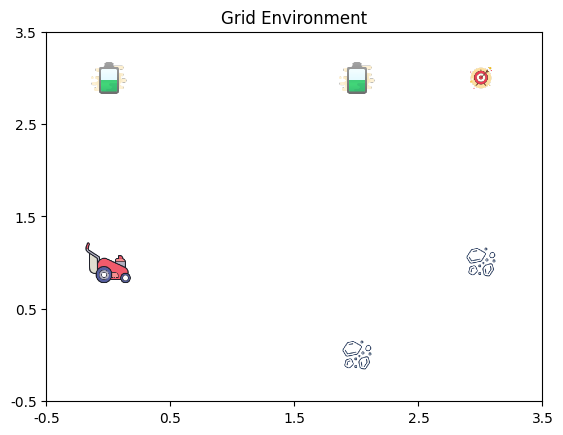

Step 2 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.2 0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


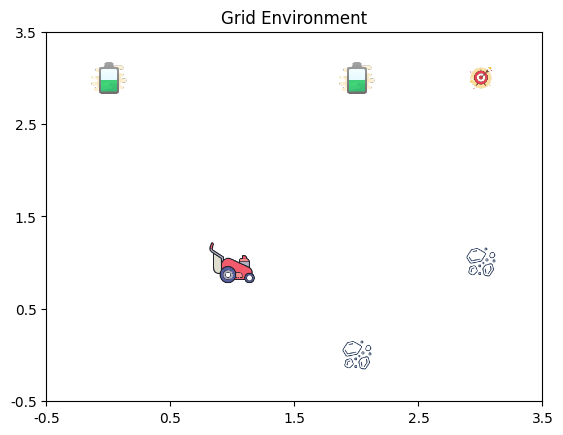

Step 3 - Action: 1, Reward: -1
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


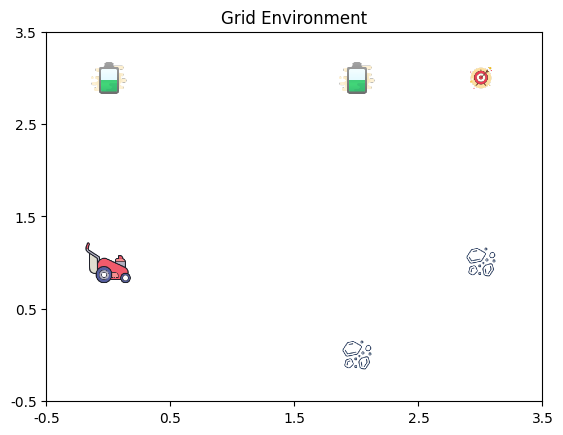

Step 4 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.2 0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


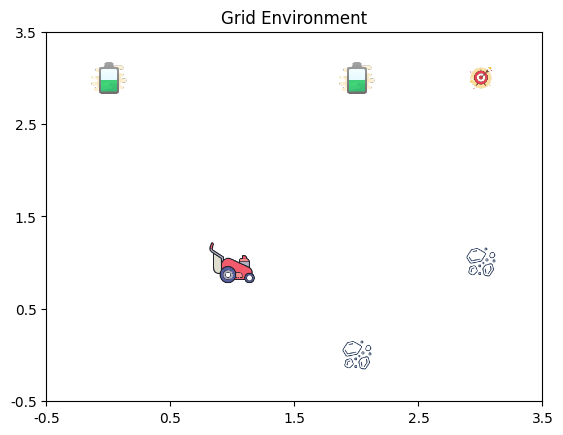

Step 5 - Action: 1, Reward: -1
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


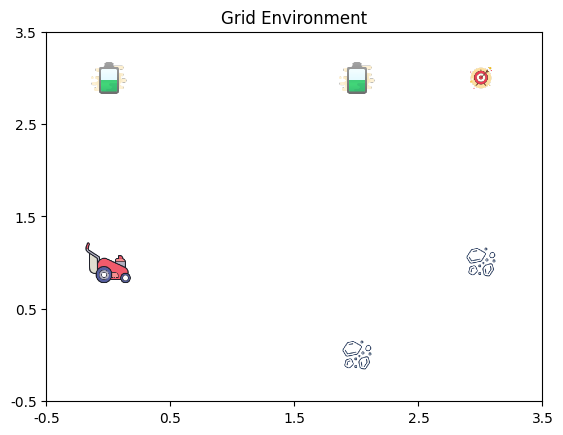

Step 6 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.2 0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


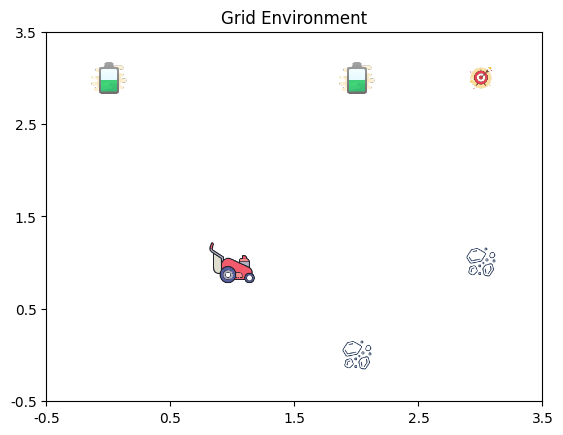

Step 7 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.2 0.  0.5]
 [0.  0.4 0.  0.8]]


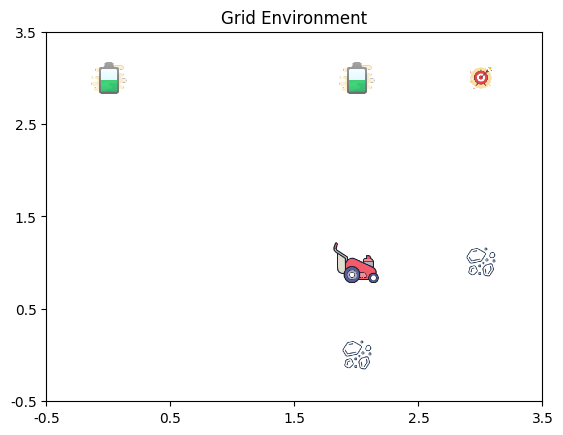

Step 8 - Action: 3, Reward: -5
Current State:
[[0.  0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.  0.4 0.  0.8]]


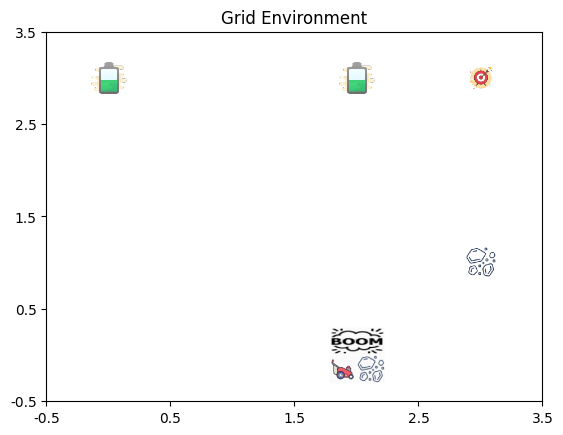

Step 9 - Action: 0, Reward: -0.1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.2 0.4 0.  0.8]]


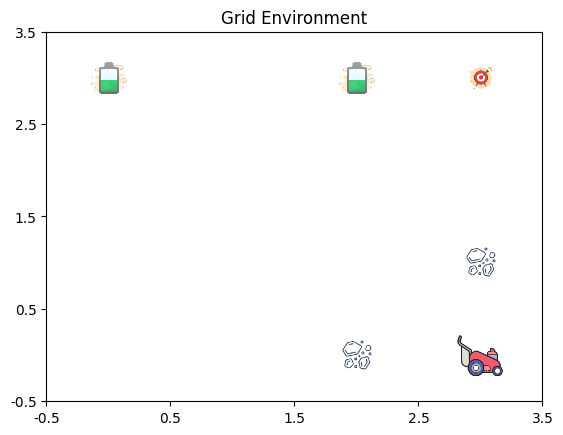

Step 10 - Action: 0, Reward: -0.1
Current State:
[[0.  0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.4 0.  0.  0.5]
 [0.2 0.4 0.  0.8]]


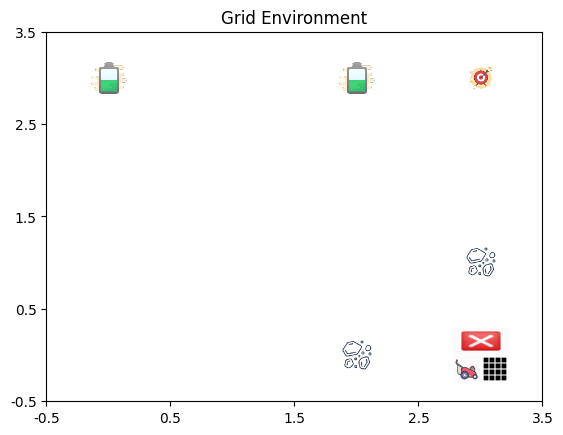

In [ ]:
env = MyLawn()
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step {_ + 1} - Action: {action}, Reward: {reward}")
    print("Current State:")
    print(env.state)
    env.render()

    if terminated or truncated:
        env.state = np.copy(env.prev_state) 
        env.myagent = np.argwhere(env.state == 0.2)[0]


## Grid-World Scenario Visualization

Add custom-defined images into your grid world env to represent:
Agent: at least two images dependent on what the agent is doing
Background: a setup that represents your scenario (different from the default one)
Images representing each object in your scenario

Initial State


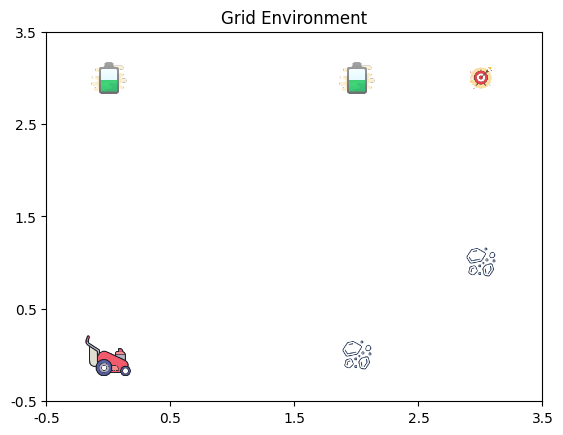

Out of the grid


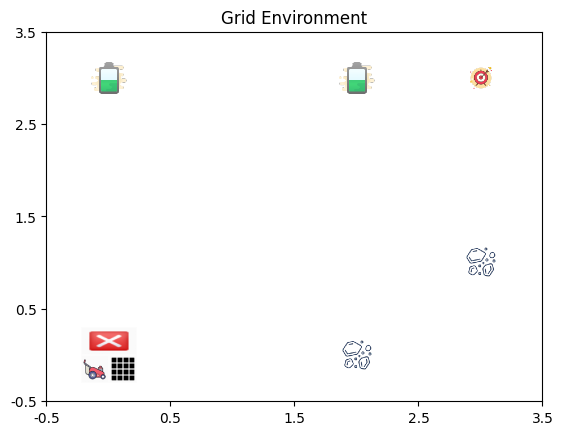

On rocks


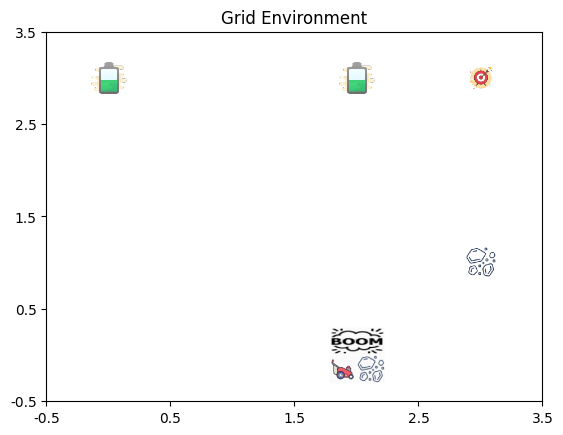

On battery


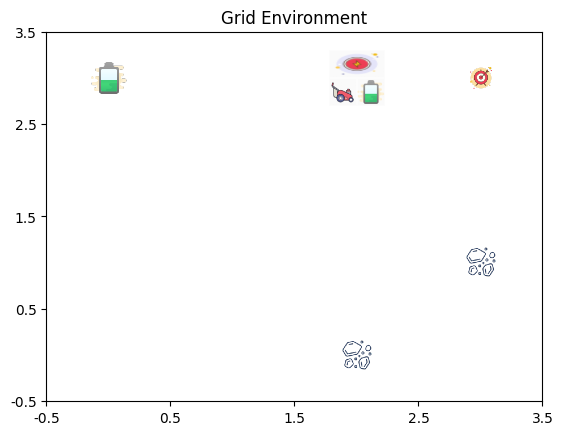

On Goal


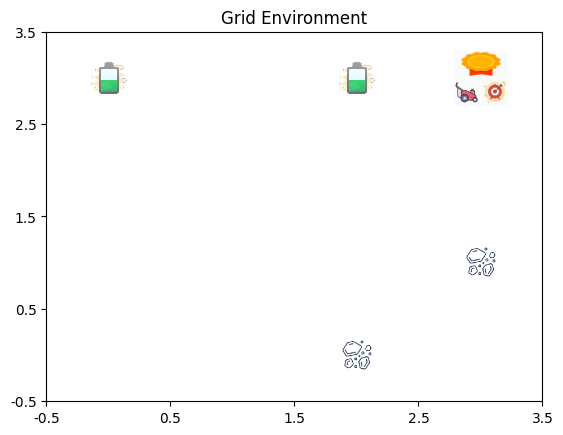

In [ ]:
# Lets display all the different states and images manually:
env = MyLawn()

# Initial State
print("Initial State")
env.render()

# Out of the grid
action = 1  #left
obs, reward, terminated, truncated, info = env.step(action)
print("Out of the grid")
env.render()

action = 0  #right
obs, reward, terminated, truncated, info = env.step(action)

# On rocks
action = 0  #right
obs, reward, terminated, truncated, info = env.step(action)
print("On rocks")
env.render()

action = 2  #up
obs, reward, terminated, truncated, info = env.step(action)

action = 2  #up
obs, reward, terminated, truncated, info = env.step(action)

# On battery
action = 2  #up
obs, reward, terminated, truncated, info = env.step(action)
print("On battery")
env.render()

# On Goal
action = 0  #right
obs, reward, terminated, truncated, info = env.step(action)
print("On Goal")
env.render()

